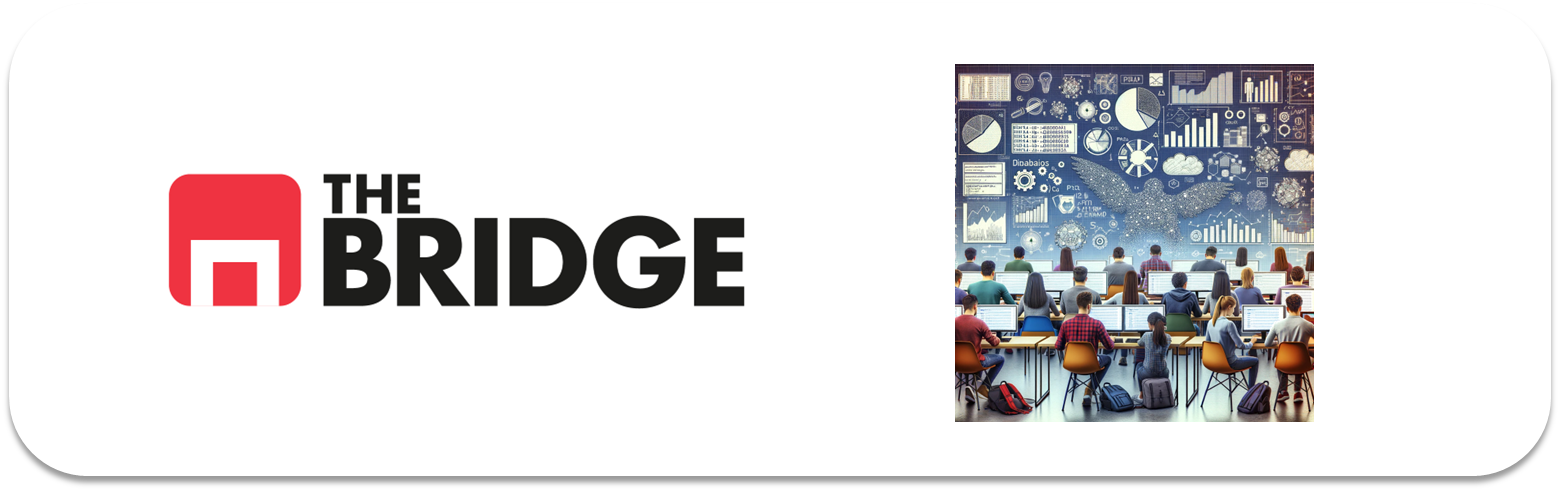

## PRACTICA OBLIGATORIA: **Clasificacion y Regresion Logistica**

* La práctica obligatoria de esta unidad consiste en modelar la supervivencia en el Titanic, por fin, además de una parte adicional multiclase. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [380]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Indicaciones

A continuación tienes las indicaciones para hacer el modelado. No necesariamente tienes que seguirlos al pie de la letra, porque a partir de ahora ya las práctica obligatorias dejarán de ser mayormente guiadas por ejercicios y serán más de libre desarrollo, aunque con objetivos específicos, claros y determinados. 

En concreto se pide hacer un modelo de regresión logística, evaluarlo contra un dataset de test reservado del original mostrando las métricas propias de los problemas de clasificación, la matriz de confusión y la curva ROC. Además se pide comparar las predicciones con los valores reales y al final adaptar el modelo a un problema multiclase.

Los pasos para guiar el trabajo:
1. Carga el dataset del Titanic. 
2. Deshazte de las variables que no vayas a usar. Limpia lo que creas necesarios pero no hagas imputaciones.
3. Escoge y analiza la variable target de forma gráfica y razona sobre el impacto de la distribución en los resultados esperados. Ten en cuenta que lo que queremos es poder predecir si un pasajero sobrevivirá.
4. Haz el split en train y test que creas conveniente pero asegurándote que ambos conjuntos tienen un reparto similar de pasajeros embarcados en las tres ciudades.
5. Construye las parejas X,y de train y test.
6. Ahora sí imputa los nulos con medias y modas en la X de train. Guarda esas medias que necesitarás en la parte de test.
7. Haz un mini-EDA, selecciona las features que quieres quedarte y por qué.
8. Trata las variables para que funcionen lo mejor posible en el modelo.
9. Construye un modelo de regresión logística.
10. EXTRA: Analiza si lo crees conveniente los pesos y la importancia de las features.
11. Procesa el dataset de Test para que puedas usarlo en la evaluación 
12. Evalúa tu modelo contra el dataset de test y train. Obten las matrices de confusión y las métricas que creas adecuadas. Haz un pequeño assesment de su generabilidad.
13. EXTRA: Halla la probabilidad de supervivencia de un hombre de entre 30 y 40 años, que embarcó en Southampton en segunda clase, viajaba solo y no pagó el billete. PISTA: En este caso tendrás que calcular varias probabilidades y hacer la media de ellas.
14. EXTRA: Aprovecha todo el trabajo haciendo un único cambio en el target, ahora será la clase del viajero. Cambia el target quitándolo de X_train, X_test y añade a estos el target anterior. El resto no deberías cambiarlo. Entrena y evalua el modelo sólo con el classification_report.  



In [381]:
# Carga el dataset del Titanic. 
df = pd.read_csv('./data/titanic.csv')

In [382]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


In [383]:
# Deshazte de las variables que no vayas a usar. Limpia lo que creas necesarios pero no hagas imputaciones.
df.drop(['alive', 'deck', 'embarked', 'class', 'parch', 'alone'], axis=1, inplace=True)

<Axes: >

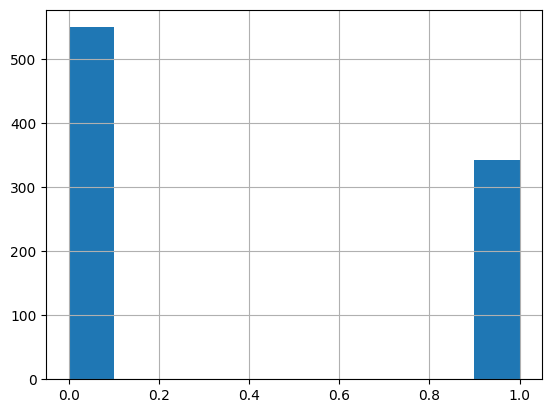

In [384]:
# Escoge y analiza la variable target de forma gráfica y razona sobre el impacto de la distribución en los resultados esperados. Ten en cuenta que lo que queremos es poder predecir si un pasajero sobrevivirá.
target = 'survived'
df[target].hist()
# Las frecuencias no están demasiado descompensadas, lo que indica que el modelo puede alcanzar buena precisión

In [385]:
df.dropna(subset=['embark_town'], inplace=True)

In [386]:
# Construye las parejas X,y de train y test.
from sklearn.model_selection import train_test_split
X = df.drop(target, axis=1)
y = df[target]

In [387]:
# Haz el split en train y test que creas conveniente pero asegurándote que ambos conjuntos tienen un reparto similar de pasajeros embarcados en las tres ciudades.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['embark_town'])

In [388]:
X_train.info() # hay solo nulos en la variable edad

<class 'pandas.core.frame.DataFrame'>
Index: 711 entries, 46 to 253
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pclass       711 non-null    int64  
 1   sex          711 non-null    object 
 2   age          573 non-null    float64
 3   sibsp        711 non-null    int64  
 4   fare         711 non-null    float64
 5   who          711 non-null    object 
 6   adult_male   711 non-null    bool   
 7   embark_town  711 non-null    object 
dtypes: bool(1), float64(2), int64(2), object(3)
memory usage: 45.1+ KB


In [389]:
# Ahora sí imputa los nulos con medias y modas en la X de train. Guarda esas medias que necesitarás en la parte de test.
X_train.age.describe() # mediana y media son muy similares, sin embargo usaremos la mediana como reemplazo porque la distribución de edad es muy asimétrica a la izquierda

count    573.000000
mean      29.710454
std       14.532155
min        0.670000
25%       20.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: age, dtype: float64

In [390]:
valor_reemplazo = X_train.age.median()

In [391]:
X_train['age'] = X_train['age'].fillna(valor_reemplazo)

In [392]:
X_train.columns
features_num = ['pclass', 'age', 'sibsp', 'fare']

(4, 2)


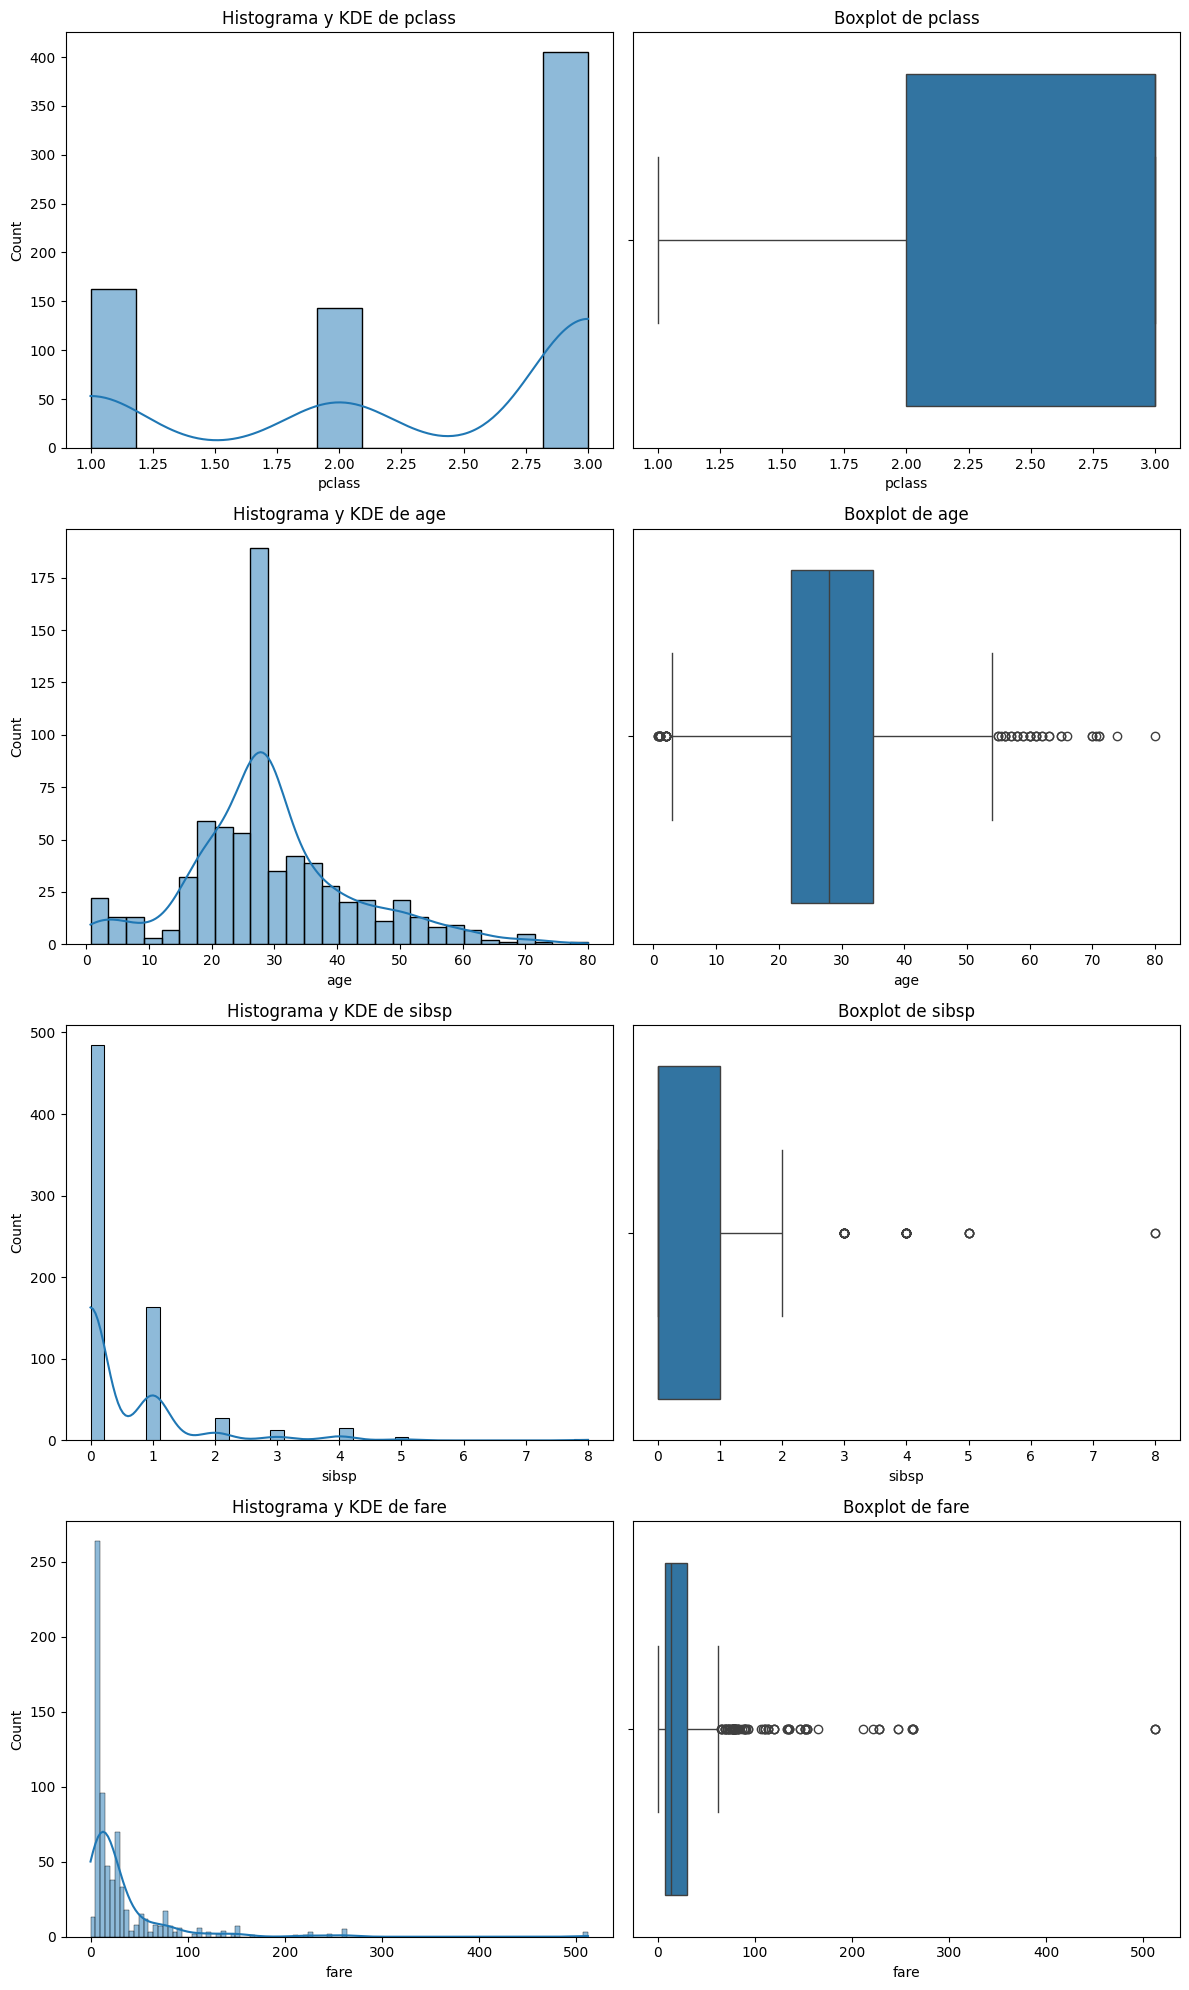

In [393]:
# Haz un mini-EDA, selecciona las features que quieres quedarte y por qué.
from bootcampviztools import *
plot_combined_graphs(X_train, features_num)

In [394]:
df_eda = X_train.copy()
df_eda["target"] = y_train.copy()
np.abs(df_eda.corr(numeric_only=True)['target']).sort_values(ascending=False)

target        1.000000
adult_male    0.575891
pclass        0.333723
fare          0.268742
age           0.044813
sibsp         0.006820
Name: target, dtype: float64

In [395]:
# Las usaremos todas las numéricas, pero forzaremos la numérica de familiares 'sibsp' a solos dos: solo o acompañado, para que tenga una distribución más pareja

In [396]:
X_train["acompañado"] = pd.cut(X_train["sibsp"], 
                               bins=[-1, 0, 8], 
                               labels=[0, 1])

In [397]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 711 entries, 46 to 253
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   pclass       711 non-null    int64   
 1   sex          711 non-null    object  
 2   age          711 non-null    float64 
 3   sibsp        711 non-null    int64   
 4   fare         711 non-null    float64 
 5   who          711 non-null    object  
 6   adult_male   711 non-null    bool    
 7   embark_town  711 non-null    object  
 8   acompañado   711 non-null    category
dtypes: bool(1), category(1), float64(2), int64(2), object(3)
memory usage: 45.9+ KB


In [398]:
X_train_prueba = X_train.copy()
X_train_prueba["target"] = y_train.copy()
X_train_prueba["acompañado"] = X_train_prueba["acompañado"].astype(int)

In [399]:
np.abs(X_train_prueba.corr(numeric_only=True)['target']).sort_values(ascending=False) # parece que es buena idea esa categorización, nos quedamos con la nueva en vez de con 'sibsp'

target        1.000000
adult_male    0.575891
pclass        0.333723
fare          0.268742
acompañado    0.123509
age           0.044813
sibsp         0.006820
Name: target, dtype: float64

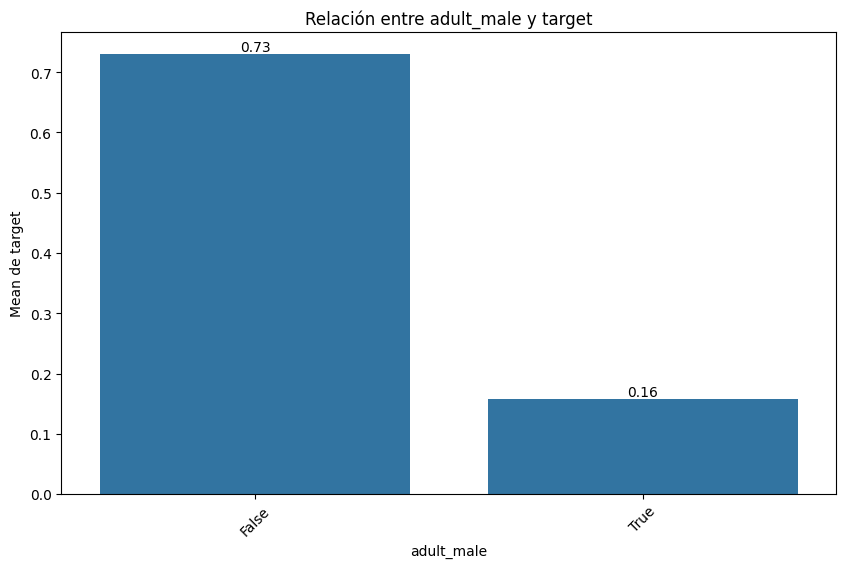

In [400]:
# Respecto a las categóricas - haremos su análisis bivariante
plot_categorical_numerical_relationship(df_eda, 'adult_male', 'target', True)

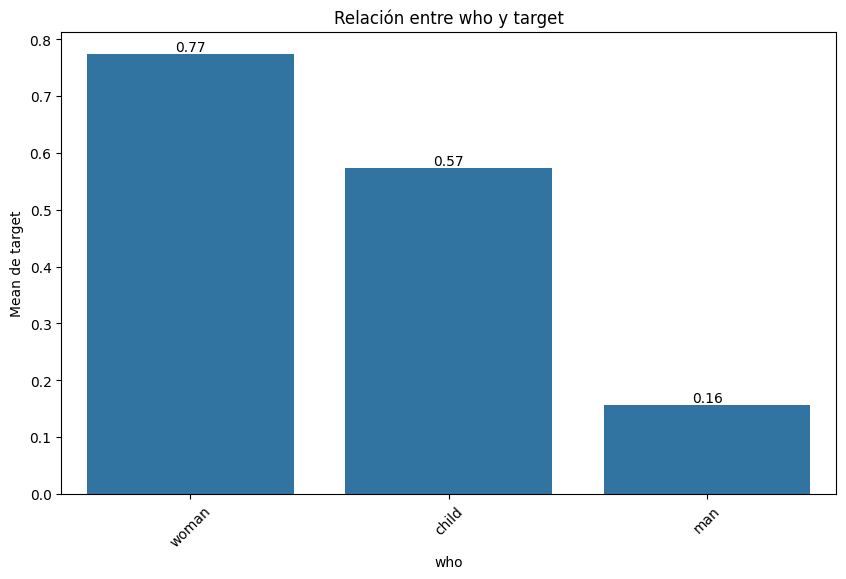

In [401]:
plot_categorical_numerical_relationship(df_eda, 'who', 'target', True)

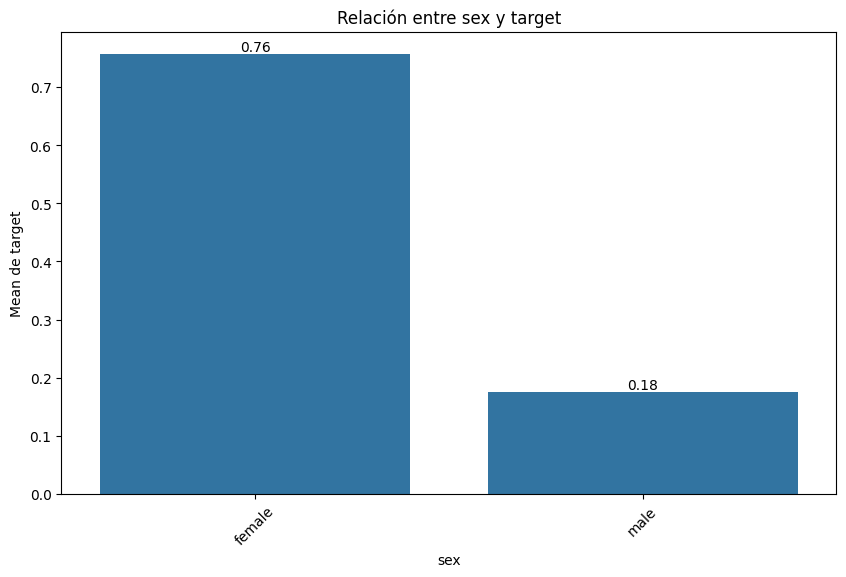

In [402]:
plot_categorical_numerical_relationship(df_eda, 'sex', 'target', True)

In [403]:
# Las tres variables arrojan la misma información. Estas dos categorías que no se pisarían: adulto o no y hombre o mujer. Vamos a pasarlas a numéricas para que funcionen bien 
from sklearn.preprocessing import OrdinalEncoder

categories_sex = [["female", 'male']] # intentamos ordenar de la categoría que tiene 'más efecto' tiene sobre sobrevivir a la que menos
ordinal_encoder = OrdinalEncoder(categories= categories_sex)
X_train["ordinal_sex"] = ordinal_encoder.fit_transform(X_train[["sex"]])

In [404]:
X_train['adult'] = X_train['who'].map({'child': 0}).fillna(1).astype(int)

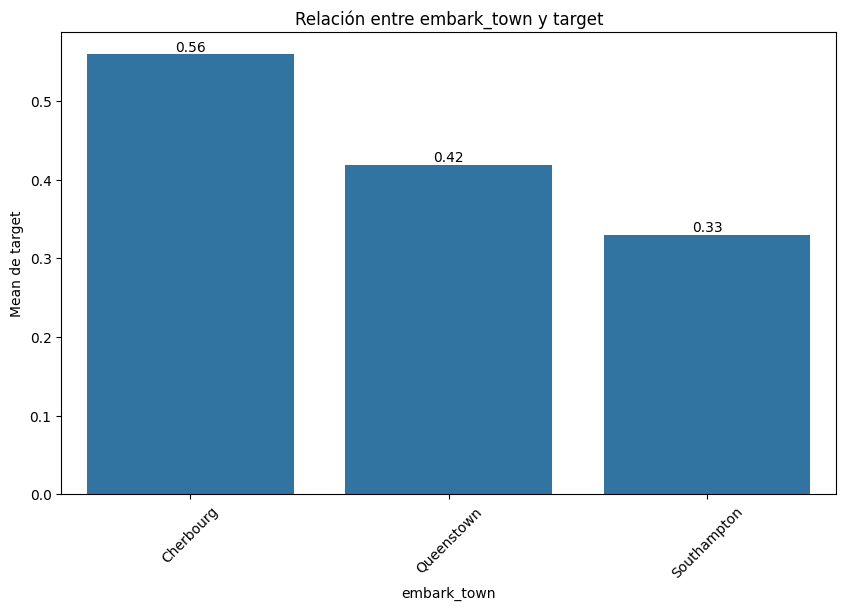

In [405]:
plot_categorical_numerical_relationship(df_eda, 'embark_town', 'target', True)

In [406]:
categories_town = [["Cherbourg", 'Queenstown', 'Southampton']] # intentamos ordenar de la categoría que tiene 'más efecto' tiene sobre sobrevivir a la que menos
ordinal_encoder = OrdinalEncoder(categories= categories_town)
X_train["ordinal_town"] = ordinal_encoder.fit_transform(X_train[["embark_town"]])

In [407]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 711 entries, 46 to 253
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   pclass        711 non-null    int64   
 1   sex           711 non-null    object  
 2   age           711 non-null    float64 
 3   sibsp         711 non-null    int64   
 4   fare          711 non-null    float64 
 5   who           711 non-null    object  
 6   adult_male    711 non-null    bool    
 7   embark_town   711 non-null    object  
 8   acompañado    711 non-null    category
 9   ordinal_sex   711 non-null    float64 
 10  adult         711 non-null    int64   
 11  ordinal_town  711 non-null    float64 
dtypes: bool(1), category(1), float64(4), int64(3), object(3)
memory usage: 62.6+ KB


In [408]:
X_train.ordinal_town.value_counts()

ordinal_town
2.0    515
0.0    134
1.0     62
Name: count, dtype: int64

In [409]:
X_train.columns

Index(['pclass', 'sex', 'age', 'sibsp', 'fare', 'who', 'adult_male',
       'embark_town', 'acompañado', 'ordinal_sex', 'adult', 'ordinal_town'],
      dtype='object')

In [410]:
# En definitiva, nos vamos a quedar con las siguientes características
features = ['pclass', 'age', 'fare', 'acompañado', 'ordinal_sex', 'adult',
       'ordinal_town']

In [411]:
# Trata las variables para que funcionen lo mejor posible en el modelo
X_train['acompañado'] = X_train['acompañado'].astype(int)

In [412]:
# Estandarizaremos las variables continuas fare y age
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

X_train["age_tr"] = std_scaler.fit_transform(X_train[['age']])
X_train["fare_tr"] = std_scaler.fit_transform(X_train[['fare']])

In [413]:
features = ['pclass', 'age', 'fare', 'acompañado', 'ordinal_sex', 'adult',
       'ordinal_town', 'age_tr', 'fare_tr']

In [414]:
X_train_bck = X_train.copy()
X_train = X_train[features]

In [415]:
# Construye un modelo de regresión logística.
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter = 5000)

log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [416]:
# Procesa el dataset de Test para que puedas usarlo en la evaluación

In [417]:
# Vamos a repetir todo lo que hemos hecho en el set de test
X_test['age'] = X_test['age'].fillna(valor_reemplazo)
X_test["acompañado"] = pd.cut(X_test["sibsp"], 
                               bins=[-1, 0, 8], 
                               labels=[0, 1])
X_test['acompañado'] = X_test['acompañado'].astype(int)

ordinal_encoder = OrdinalEncoder(categories= categories_sex)
X_test["ordinal_sex"] = ordinal_encoder.fit_transform(X_test[["sex"]])

X_test['adult'] = X_test['who'].map({'child': 0}).fillna(1).astype(int)

ordinal_encoder = OrdinalEncoder(categories= categories_town)
X_test["ordinal_town"] = ordinal_encoder.fit_transform(X_test[["embark_town"]])

X_test["age_tr"] = std_scaler.fit_transform(X_test[['age']])
X_test["fare_tr"] = std_scaler.fit_transform(X_test[['fare']])

X_test_bck = X_test.copy()
X_test = X_test[features]


In [420]:
# Evalúa tu modelo contra el dataset de test y train. 
from sklearn.metrics import accuracy_score

acc_train = round(accuracy_score(log_reg.predict(X_train), y_train), 3)
acc_test = round(accuracy_score(log_reg.predict(X_test), y_test), 3)

print("Accuracy train:", acc_train)
print("Accuracy test:", acc_test)

Accuracy train: 0.796
Accuracy test: 0.753


In [422]:
y_test.value_counts(True)

survived
0    0.61236
1    0.38764
Name: proportion, dtype: float64

##### Aunque no es una accuracy muy alta, se consigue mejorar la que da de por sí el dataset

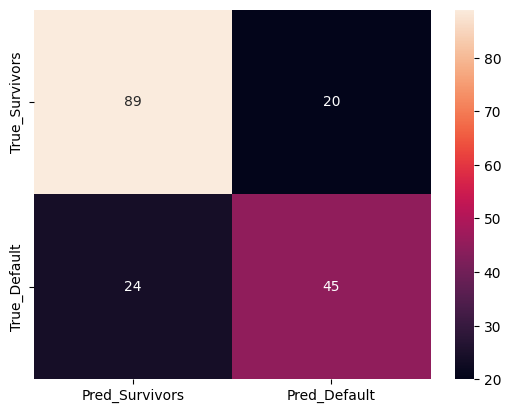

In [423]:
# Obten las matrices de confusión y las métricas que creas adecuadas. 
from sklearn.metrics import confusion_matrix

c_matrix = confusion_matrix(y_test, log_reg.predict(X_test))

c_matrix_df = pd.DataFrame(c_matrix, columns = ['Pred_Survivors', 'Pred_Default'],
                          index = ['True_Survivors', 'True_Default'])

sns.heatmap(c_matrix_df, annot=True, fmt='g');

c:\Users\Eva\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


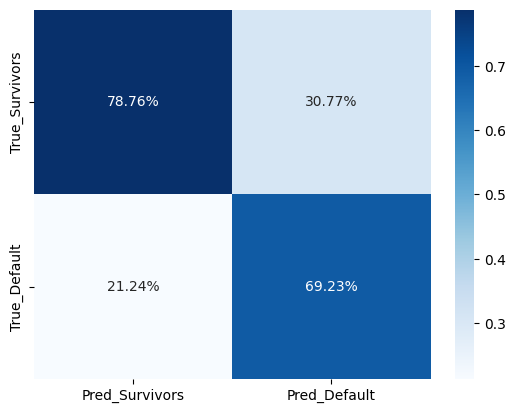

In [424]:
sns.heatmap(c_matrix_df/np.sum(c_matrix_df), annot=True, 
            fmt='.2%', cmap='Blues');

In [426]:
from sklearn.metrics import classification_report
from pprint import pprint

print(classification_report(y_test, log_reg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80       109
           1       0.69      0.65      0.67        69

    accuracy                           0.75       178
   macro avg       0.74      0.73      0.74       178
weighted avg       0.75      0.75      0.75       178



AUROC: 0.84


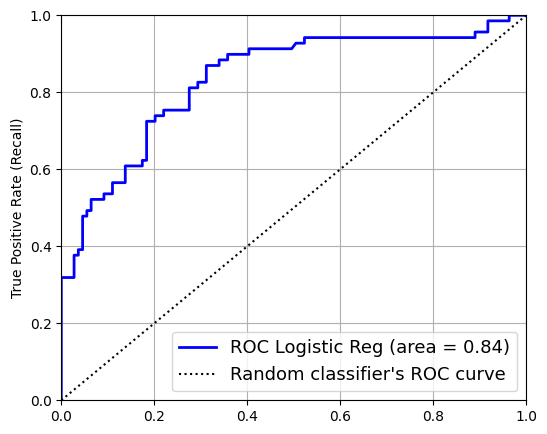

In [425]:
from sklearn.metrics import roc_curve, auc

scores = log_reg.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, scores[:,1])
roc_auc = auc(fpr,tpr)
print("AUROC: %.2f" %(roc_auc))
plt.figure(figsize=(6, 5))  
plt.plot(fpr, tpr, linewidth=2, color= "blue", label=f"ROC Logistic Reg (area = {roc_auc:0.2f})")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

In [428]:
# Haz un pequeño assesment de su generabilidad.

El AUC sugiere que el modelo tiene una buena capacidad para generalizar, sin embargo, las métricas de precisión, recall y F1 arrojan que el modelo tiene problemas para detectar correctamente la clase 1, que el viajero muriera dadas unas características. El recall de 0.65 en la clase 1 hace anticipar una tasa de falsos negativos demasiado alta, ya que la clase de los fallecidos es la crítica en este caso.
El promedio para precision (0.74), recall (0.73) y F1 (0.74) refleja un rendimiento moderado general para ambas clases.
En resumen, el modelo tal cuál es aceptable, pero convendría buscar mejor combinación o tratamiento de las variables para tratar de mejorar las métricas de evaluación.